In [1]:
"""
@author: Vu Hoang Viet
"""

import os
import sys
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from utils import lmdb_dataset_loader
import matplotlib.pyplot as plt
import cv2
import time
import torch.nn.functional as F
from torchsummary import summary

In [2]:
torch.max(torch.tensor([1,2,3]))

tensor(3)

In [3]:
class Extraction(nn.Module):

    def __init__(self):
        super(Extraction, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=4, stride=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=4, out_channels=4, kernel_size=4, stride=1, bias=False),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=4, stride=2),
            nn.Conv2d(in_channels=4, out_channels=16, kernel_size=4, stride=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=4, stride=1, bias=False),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=4, stride=1),
            nn.Conv2d(in_channels=16, out_channels=64, kernel_size=4,stride=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4,stride=1, bias=False),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=4, stride=2),
        )

    def forward(self, input):
        """

        @param input:
        @return:
        """
        output = self.model(input)
        return output


class Generator(nn.Module):
    def __init__(self, input_dim, max_features = 10):
        super(Generator, self).__init__()
        self.device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
        
        self.input_dim = input_dim
        self.max_features = max_features
        self.extractor = Extraction()
        
        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64*10, out_channels=64, kernel_size=4, stride=2, bias=False),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, bias=False),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=64, out_channels=16, kernel_size=4, stride=2, bias=False),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, bias=False),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=16, out_channels=4, kernel_size=3, stride=1, bias=False),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=4, out_channels=4, kernel_size=4, stride=1, bias=False),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=4, out_channels=1, kernel_size=4, stride=1, bias=False),
            nn.Tanh()
        )

    def forward(self, input_imgs):
        """
        @param input:
        @return:
        """
        for input_img in input_imgs:
            input_img = torch.tensor(input_img).to(self.device)
            features_out = self.extractor(input_img.float())
            empty = torch.zeros((self.max_features - len(features_out),
                                 features_out.shape[1],
                                 features_out.shape[2],
                                 features_out.shape[3])).to(self.device)
            features_out = torch.cat(
                [features_out,empty
                 ],dim  = 0)
            features_out = features_out.reshape(1, 64*self.max_features,features_out.shape[2], features_out.shape[3])
            try:
                features_outs = torch.cat(
                    [features_outs,features_out
                     ],dim  = 0)
            except:
                features_outs = features_out
        output = self.model(torch.tensor(features_outs))
        return output


class Discriminator(nn.Module):
    def __init__(self, num_classes):
        super(Discriminator, self).__init__()
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, bias=False),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=4, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, bias=False),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=4, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, bias=False),
            nn.ReLU(True),
            nn.Flatten()
        )
        self.fake_real_model = nn.Linear(3136, 2)
        self.property_model = nn.Linear(3136, num_classes)

    def forward(self, input):
        """
        @param input:
        @return:
        """
        feature = self.feature_extraction(input)
        fake_real = self.fake_real_model(feature)
        property = self.property_model(feature)
        return fake_real, property

In [4]:
class HandWrittenGan:
    """
    Model class
    """

    def __init__(self,
                 input_dim,
                 target_size=(64, 64),
                 input_path=None,
                 target_path=None,
                 classes=None,
                 batch_size=1,
                 max_features=10,
                 max_iter=1e+5,
                 check_times = 1e+3):
        self.device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
        self.input_dim = input_dim
        self.classes = classes
        self.num_classes = len(classes)
        self.max_features = max_features
        self.real_label = 1
        self.fake_label = 0
        
        self.input_data = lmdb_dataset_loader(input_path)
        self.target_data = lmdb_dataset_loader(target_path)
        self.target_size = target_size
        self.batch_size = batch_size
        self.max_iter = max_iter
        self.check_times = check_times
        
        self.generator = Generator(input_dim).to(self.device)
        self.discriminator = Discriminator(self.num_classes).to(self.device)
        self.logs = {}

    def data_loader(self):
        while True:
            labels = []
            input_imgs = []
            real_imgs = []
            for _ in range(self.batch_size):
                label_ind = np.random.randint(self.num_classes)
                label = self.classes[label_ind]
                input_img = []
                for _ in range(2):
                    img = np.array(self.input_data.random_sample(label))
                    img = cv2.resize(img, self.target_size, interpolation = cv2.INTER_AREA)
                    img = np.reshape(img, (1,self.target_size[0],self.target_size[1]))
                    input_img.append(img)
                for i in range(2,10):
                    if np.random.rand() < 0.5:
                        img = np.array(self.input_data.random_sample(label))
                        img = cv2.resize(img, self.target_size, interpolation = cv2.INTER_AREA)
                        img = np.reshape(img, (1,self.target_size[0],self.target_size[1]))
                    else:
                        img = np.zeros_like(img)
                    input_img.append(img)
                real_img = np.array(self.target_data.random_sample(label))
                real_img = cv2.resize(real_img, self.target_size, interpolation = cv2.INTER_AREA)
                real_img = np.reshape(real_img, (1,self.target_size[0],self.target_size[1]))
                labels.append(label_ind)
                input_imgs.append(input_img)
                real_imgs.append(real_img)
            yield np.array(labels), np.array(input_imgs), np.array(real_imgs)

    def trainer(self, epochs):
        """

        @return:
        """
        optimizerD = optim.Adam(self.discriminator.parameters(), lr=1e-3, betas=(0.1, 0.999))
        optimizerG = optim.Adam(self.generator.parameters(), lr=1e-3, betas=(0.1, 0.999))
#         optimizerD = optim.SGD(self.discriminator.parameters(), lr=1e-2, momentum=0.9)
#         optimizerG = optim.SGD(self.generator.parameters(), lr=1e-2, momentum=0.9)
        self.logs['d_loss_real'] = []
        self.logs['d_loss_fake'] = []
        self.logs['d_loss_cls_real'] = []
        loss_d1 = nn.CrossEntropyLoss()
        loss_d2 = nn.CrossEntropyLoss()
        loss_g = nn.CrossEntropyLoss()
        running_d_loss = 0
        running_g_loss = 0
        real_loss_plot = []
        fake_loss_plot = []
        mean_loss_plot = []
        for epoch in range(epochs):
            count = 0
            b = time.time()
            for labels, input_imgs, real_imgs in self.data_loader():
                if count >= self.max_iter:
                    break
                else:
                    count += 1
                optimizerD.zero_grad()
                real_imgs = torch.tensor(real_imgs).to(self.device)

                # Đánh label true fake images
                true_label = torch.full((self.batch_size,), self.real_label,dtype=torch.long,
                                             device=self.device)
                fake_label = torch.full((self.batch_size,), self.fake_label,dtype=torch.long,
                                             device=self.device)

                # Đánh label phân loại
                property_label = torch.tensor(labels,dtype=torch.long,
                                             device=self.device)

                # Training model D với ảnh reals
#                 for real_img in real_imgs:
#                     plt.imshow(real_img.cpu().detach().numpy()[0])
#                     plt.show()
                real_imgs = real_imgs.float().to(self.device)
                out_real_src, out_real_cls = self.discriminator(real_imgs)
                d_loss_real = loss_d1(out_real_src, true_label)
                d_loss_cls_real = loss_d2(out_real_cls, property_label)

#                 # Tạo ảnh fake bằng G-models từ features từ E-Models
                input_imgs = torch.tensor(input_imgs)
                x_fake = self.generator(input_imgs)

# #                 # Training models D với ảnh fake
                out_fake_src, _ = self.discriminator(x_fake.detach())
                d_loss_fake = loss_d1(out_fake_src,fake_label)
                
                d_loss = d_loss_real + d_loss_cls_real
                d_loss.backward()
                optimizerD.step()
                running_d_loss += d_loss.item()
                
#                 if count % (self.check_times//10) == 0:
                optimizerG.zero_grad()
                x_fake = self.generator(input_imgs)
                out_fake_src, out_fake_cls = self.discriminator(x_fake.detach())
                g_loss_fake = loss_d1(out_fake_src, true_label)
                g_loss_cls_fake = loss_g(out_fake_cls, property_label)
                g_loss = g_loss_fake + g_loss_cls_fake
                running_g_loss += g_loss.item()
                g_loss.backward()
                optimizerG.step() 
                    
                if count % self.check_times == 0:
                    d_loss = running_d_loss/self.check_times
                    g_loss = running_g_loss/(self.check_times//10)
                    real_loss_plot.append(d_loss)
                    fake_loss_plot.append(g_loss)
                    mean_loss_plot.append((d_loss+g_loss)/2)
                    print("[%3d,%10d], D_Loss: %10f, G_Loss: %10f, Mean Loss: %5f, Seconds/batch: %5f"%(epoch, count,d_loss, g_loss, (d_loss+g_loss)/2, time.time() - b))
                    b = time.time()
                    running_d_loss = 0
                    running_g_loss = 0  
                    if count % (self.check_times*10) == 0:
                        plt.subplot(2, 1, 1)
                        plt.plot(real_loss_plot, label='d_loss')
                        plt.plot(fake_loss_plot, label='g_loss')
                        plt.plot(mean_loss_plot, label='mean_loss')
                        plt.show()
            fig=plt.figure(figsize=(4, 2))
            fig.add_subplot(1, 2, 1)
            plt.imshow(real_imgs[0][0])
            fig.add_subplot(1, 2, 2)
            plt.imshow(x_fake.cpu().detach().numpy()[0][0])
            plt.show()
            print("Epochs %2d finished."%epoch)
                    

    def predictor(self):
        """

        @return:
        """
        return

In [5]:
models = HandWrittenGan(
                 input_dim = 5,
                 target_size=(64, 64),
                 input_path='/home/vietvh9/Project/OCR_Components/data/sources/synthtext_font_lmdb',
                 target_path='/home/vietvh9/Project/OCR_Components/data/sources/ETL_NIST_processed_v2.0_lmdb',
                 classes=[str(i) for i in range(2)],
                 batch_size=10,
                 max_features=10,
                 max_iter=1e+5,
                 check_times = 1e+2)

/home/vietvh9/Project/.envs/GAN/lib/python3.6/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/vietvh9/Project/.envs/GAN/lib/python3.6/site-packages/ipykernel_launcher.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[  0,       100], D_Loss:   0.284970, G_Loss:  13.880105, Mean Loss: 7.082537, Seconds/batch: 7.508154
[  0,       200], D_Loss:   0.166305, G_Loss:  13.880380, Mean Loss: 7.023342, Seconds/batch: 7.440787
[  0,       300], D_Loss:   1.410330, G_Loss:  13.870677, Mean Loss: 7.640503, Seconds/batch: 7.466636
[  0,       400], D_Loss:   0.032037, G_Loss:  13.865704, Mean Loss: 6.948870, Seconds/batch: 7.411375
[  0,       500], D_Loss:   0.025133, G_Loss:  13.867109, Mean Loss: 6.946121, Seconds/batch: 7.413241
[  0,       600], D_Loss:   0.020757, G_Loss:  13.865495, Mean Loss: 6.943126, Seconds/batch: 7.383502
[  0,       700], D_Loss:   0.054540, G_Loss:  13.865478, Mean Loss: 6.960009, Seconds/batch: 7.404816
[  0,       800], D_Loss:   0.018969, G_Loss:  13.857545, Mean Loss: 6.938257, Seconds/batch: 7.448811
[  0,       900], D_Loss:   0.019169, G_Loss:  13.857027, Mean Loss: 6.938098, Seconds/batch: 7.463930
[  0,      1000], D_Loss:   0.047619, G_Loss:  13.857093, Mean Loss: 6.95

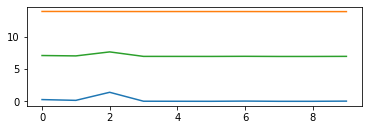

[  0,      1100], D_Loss:   0.015587, G_Loss:  13.851405, Mean Loss: 6.933496, Seconds/batch: 7.495515


In [ ]:
models.trainer(10)

In [ ]:
loss = nn.CrossEntropyLoss()
input = torch.tensor([[0.9,0.1,0],[0,1,0]],dtype = torch.long)
target = torch.tensor([0,1],dtype = torch.long)
output = loss(input, target)
output

In [ ]:
output = loss(input, target)

In [ ]:
target